<a href="https://colab.research.google.com/github/utkutopuz/ArduinoandCplusplus/blob/main/bootcampstudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Data is prepared and it needs to be preprocessed.

In [3]:
!pip install kaggle


In [4]:
from google.colab import files
files.upload()  # Upload the kaggle.json file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [5]:
!kaggle competitions download -c dog-breed-identification

dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
zip_file_path = '/content/dog-breed-identification.zip'

# Specify the target directory for unzipping
target_dir = '/content/dog-breed-identification'

# Unzip the file
!unzip -q $zip_file_path -d $target_dir

replace /content/dog-breed-identification/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
dataset_path = '/content/dog-breed-identification/labels.csv'
df = pd.read_csv(dataset_path)


In [8]:
# Display the first few rows of the dataframe
df.head()



,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
df.shape

(10222, 2)

<Axes: xlabel='breed', ylabel='count'>

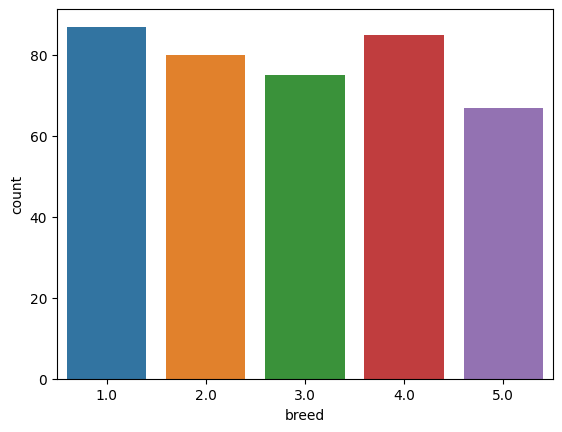

In [10]:
dog_breed_categories = {
    "boston_bull": 1,
    "dingo": 2,
    "pekinese": 3,
    "bluetick": 4,
    "golden_retriever": 5
}
sns.countplot(x=df["breed"].map(dog_breed_categories))

In [11]:
# Extract features (pixel values) and breeds
X = df.drop('breed', axis=1)  # breed is the column name for the dog breeds
y = df['breed']


In [12]:
#Label Encoding
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
path = '/content/dog-breed-identification/train'
target_shape = (128, 128, 3)

def load_and_preprocess_image(id_path, target_shape):
    img = plt.imread(id_path)
    img = cv2.resize(img, (target_shape[1], target_shape[0]))  # Resize the image
    return img

Load and preprocess images to an array of RGB colors

In [14]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(id_path, target_shape):
    img = plt.imread(id_path)
    img = cv2.resize(img, (target_shape[1], target_shape[0]))  # Resize the image
    return img

def load_and_preprocess_images(directory_path, target_shape):
    image_list = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"):
            file_path = os.path.join(directory_path, filename)
            img = load_and_preprocess_image(file_path, target_shape)
            image_list.append(img)

    return np.array(image_list)

# Example usage
path = '/content/dog-breed-identification/train'
target_shape = (128, 128, 3)

images_array = load_and_preprocess_images(path, target_shape)

# Check the shape of the resulting array
print(images_array.shape)


(10222, 128, 128, 3)



'images_array' is already loaded and preprocessed

> Indented block



> Indented block



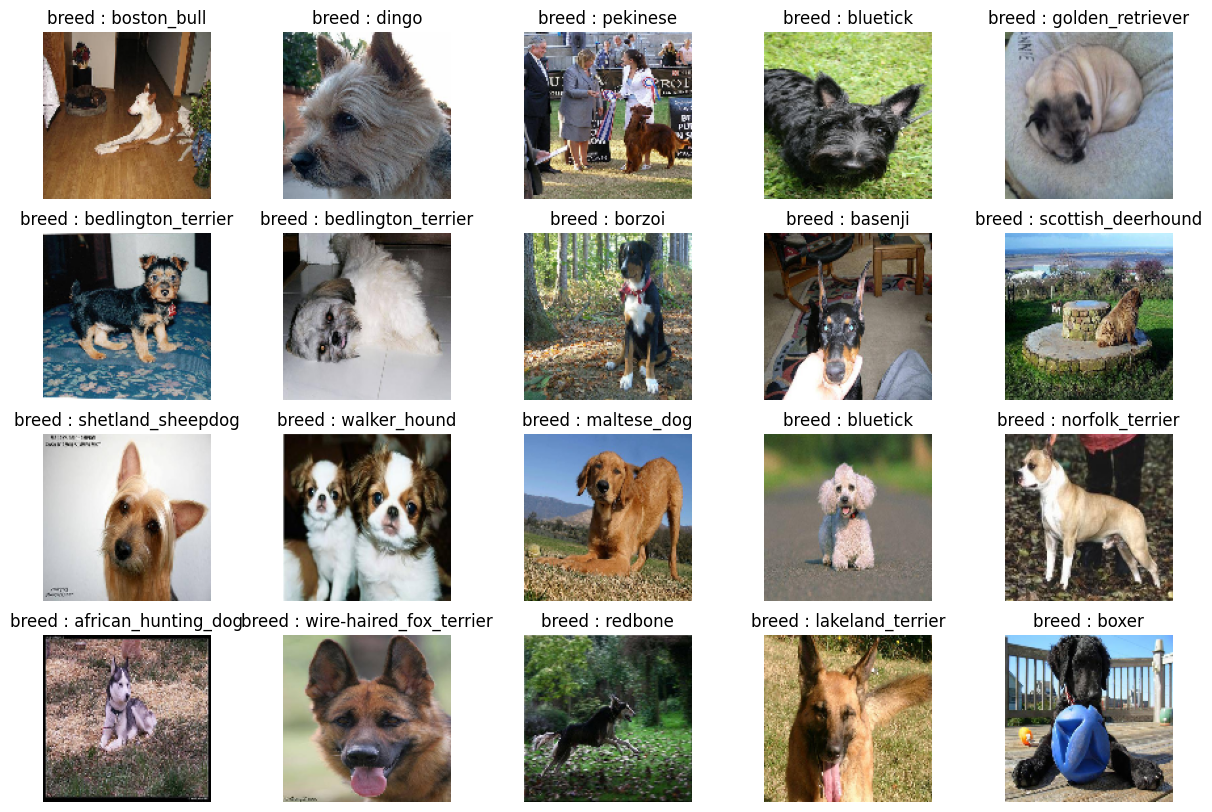

In [15]:
import matplotlib.pyplot as plt
#plotting first 20 images of the data
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images_array[i])
    plt.title('breed : {x}'.format(x=df["breed"][i]))
    plt.axis('off')

plt.show()


In [16]:

# Assuming df is your dataframe with 'breed' column
# Assuming Label Encoding for simplicity
le = LabelEncoder()
y = le.fit_transform(df['breed'])
y = to_categorical(y, num_classes=120)  # Assuming 120 breeds

In [17]:
from sklearn.model_selection import train_test_split

# Assuming df is your dataframe with 'breed' column and images_array contains preprocessed images

# Split the data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(images_array, df['breed'], test_size=0.2, random_state=42)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (8177, 128, 128, 3)
Validation set shape: (1022, 128, 128, 3)
Test set shape: (1023, 128, 128, 3)


In [18]:
# Normalize pixel values to the range [0, 1]
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0
X_test_normalized = X_test / 255.0

# Print the shapes of the normalized sets
print("Normalized Training set shape:", X_train_normalized.shape)
print("Normalized Validation set shape:", X_val_normalized.shape)
print("Normalized Test set shape:", X_test_normalized.shape)

Normalized Training set shape: (8177, 128, 128, 3)
Normalized Validation set shape: (1022, 128, 128, 3)
Normalized Test set shape: (1023, 128, 128, 3)


Building Model

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Assuming X_train_normalized, y_train, X_val_normalized, y_val are your training and validation sets

# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))  # Assuming 120 breeds

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [20]:
# One-hot encode the labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train), num_classes=120)
y_val_encoded = to_categorical(le.transform(y_val), num_classes=120)

In [ ]:
# Train the model
history = model.fit(X_train_normalized, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val_normalized, y_val_encoded))

# Plot model's accuracy and loss
plt.figure(figsize=(12, 4))

# Plot Training & Validation Accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

